In [169]:
# Pip imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import stan

try:
    import arviz as az
except ImportError as err:
    print("Please, install arviz for easy visualization of Stan models.")

import nest_asyncio
nest_asyncio.apply()

import pandas as pd

print(stan.__version__)

3.10.0


In [ ]:
stan_code = """

data {
    int<lower=1> N;
    //real tau_0;
    //real tau_1;
    //real sigma_a;
    //real sigma_b;
    matrix[N, 3] x;
    vector[N] y;
}

parameters {
    real<lower=0> sigma;
    real alpha;
    vector[3] beta;
}

//transformed parameters {
//  matrix[3, 3] I;
//
//  for(i in 1: 3){
//    for(j in 1:3){
//      if(i == j){
//        I[i, j] = 1.0;
//      }
//      else{
//        I[i, j] = 0.0;
//      }
//    }
//  }

//}

model {
    sigma ~ inv_gamma(0.1, 1);
    alpha ~ normal(0, 0.1);
    beta ~ normal(0, 1);

    // sigma ~ inv_gamma(tau_0, tau_1);
    // alpha ~ normal(0, sigma_a);
    // beta ~ multi_normal(rep_vector(0, 3), 1 * I);

    // y ~ multi_normal(x * beta, sigma);

    for (n in 1:N) {
        y[n] ~ normal(alpha + beta' * (x[n]'), sigma);
    }
}

generated quantities{
  array[N] real pred_distr;
  for(i in 1:N){
    pred_distr[i] = normal_rng(alpha + beta' * (x[i]'), sigma);
  }
}

"""

In [171]:
# Read in the file
insurance_data = pd.read_csv("insurance.csv")

insurance_data = insurance_data.sample(frac=1).reset_index(drop=True)

key_param_df = insurance_data[['age', 'bmi', 'children']].astype(np.float64)

# Standardize the data in these columns

for col in key_param_df:
    key_param_df[col] = (key_param_df[col] - key_param_df[col].mean())/(key_param_df[col].std())

# Also standardize the charges
insurance_data["charges"] = (insurance_data['charges'] - insurance_data['charges'].mean())/(insurance_data['charges'].std())

parameter_vals = key_param_df.values
charges_vals = insurance_data["charges"].values

num_rows = parameter_vals.shape[0]

split_proportion = 0.2
split_row = int(num_rows * split_proportion)

training_data_params = parameter_vals[split_row:, :]
testing_data_params = parameter_vals[:split_row, :]

training_data_charges = charges_vals[split_row:]
testing_data_charges = charges_vals[:split_row]

print(f"Shape of Total Data Set: {charges_vals.shape}")
print(f"Split Row: {split_row}")
print(f"Shape of Training Set: {training_data_charges.shape}")
print(f"Shape of Test Set: {testing_data_charges.shape}")

Shape of Total Data Set: (1338,)
Split Row: 267
Shape of Training Set: (1071,)
Shape of Test Set: (267,)


In [172]:

data_dict = {
    'N': training_data_charges.shape[0],
    # 'tau_0': 0.3,
    # 'tau_1': 0.6,
    # 'sigma_a': 5,
    # 'sigma_b': 1,
    #'x': np.ndarray(key_param_df.values, dtype=float)
    'x': training_data_params,
    'y': training_data_charges
}

model = stan.build(stan_code, data=data_dict)

Building...

In file included from /home/smidta/anaconda3/envs/cognitive/lib/python3.12/site-packages/httpstan/include/tbb/concurrent_unordered_map.h:26,
                 from /home/smidta/anaconda3/envs/cognitive/lib/python3.12/site-packages/httpstan/include/stan/math/rev/core/profiling.hpp:10,
                 from /home/smidta/anaconda3/envs/cognitive/lib/python3.12/site-packages/httpstan/include/stan/math/rev/core.hpp:53,
                 from /home/smidta/anaconda3/envs/cognitive/lib/python3.12/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/smidta/anaconda3/envs/cognitive/lib/python3.12/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/smidta/anaconda3/envs/cognitive/lib/python3.12/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/smidta/.cache/httpstan/4.13.0/models/lg5r6xsm/model_lg5r6xsm.cpp:2:
/home/smidta/anaconda3/envs/cognitive/lib/python3.12/site-packages/httpstan/include/tbb/internal/_


Building: 20.1s, done.

In [173]:
fit = model.sample(num_chains=4, num_samples=2000, num_warmup=1000)

Sampling:   0%
Sampling:   1% (100/12000)
Sampling:   2% (200/12000)
Sampling:   2% (300/12000)
Sampling:   3% (400/12000)
Sampling:   5% (600/12000)
Sampling:   8% (900/12000)
Sampling:  10% (1200/12000)
Sampling:  12% (1500/12000)
Sampling:  15% (1800/12000)
Sampling:  18% (2100/12000)
Sampling:  20% (2400/12000)
Sampling:  22% (2700/12000)
Sampling:  36% (4300/12000)
Sampling:  55% (6600/12000)
Sampling:  74% (8900/12000)
Sampling:  93% (11200/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 0.000595 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.95 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_a1rv6e6i/model_lg5r6xsm.stan', line 47, column 8 to column 54)
  If this 

In [174]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.952,0.021,0.911,0.989,0.000,0.000,10594.0,6514.0,1.0
alpha,0.005,0.029,-0.050,0.059,0.000,0.000,11186.0,6591.0,1.0
beta[0],0.282,0.029,0.229,0.338,0.000,0.000,9917.0,6289.0,1.0
beta[1],0.168,0.029,0.113,0.223,0.000,0.000,10990.0,6143.0,1.0
beta[2],0.056,0.030,0.003,0.113,0.000,0.000,9210.0,6492.0,1.0
...,...,...,...,...,...,...,...,...,...
pred_distr[1066],0.469,0.965,-1.349,2.286,0.011,0.008,8147.0,8016.0,1.0
pred_distr[1067],-0.650,0.962,-2.408,1.217,0.011,0.008,8181.0,8130.0,1.0
pred_distr[1068],-0.505,0.952,-2.270,1.329,0.011,0.008,8052.0,7714.0,1.0
pred_distr[1069],-0.316,0.945,-2.084,1.443,0.011,0.008,8072.0,7943.0,1.0


/home/smidta/anaconda3/envs/cognitive/lib/python3.12/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (1076), generating only 20 plots
  warnings.warn(


array([[<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'beta\n0'}>],
       [<Axes: title={'center': 'beta\n1'}>,
        <Axes: title={'center': 'beta\n1'}>],
       [<Axes: title={'center': 'beta\n2'}>,
        <Axes: title={'center': 'beta\n2'}>],
       [<Axes: title={'center': 'pred_distr\n0'}>,
        <Axes: title={'center': 'pred_distr\n0'}>],
       [<Axes: title={'center': 'pred_distr\n1'}>,
        <Axes: title={'center': 'pred_distr\n1'}>],
       [<Axes: title={'center': 'pred_distr\n2'}>,
        <Axes: title={'center': 'pred_distr\n2'}>],
       [<Axes: title={'center': 'pred_distr\n3'}>,
        <Axes: title={'center': 'pred_distr\n3'}>],
       [<Axes: title={'center': 'pred_distr\n4'}>,
        <Axes: title={'center': 'pred_distr\n4'}>],
       [<Axes: title={'center': 'pred_

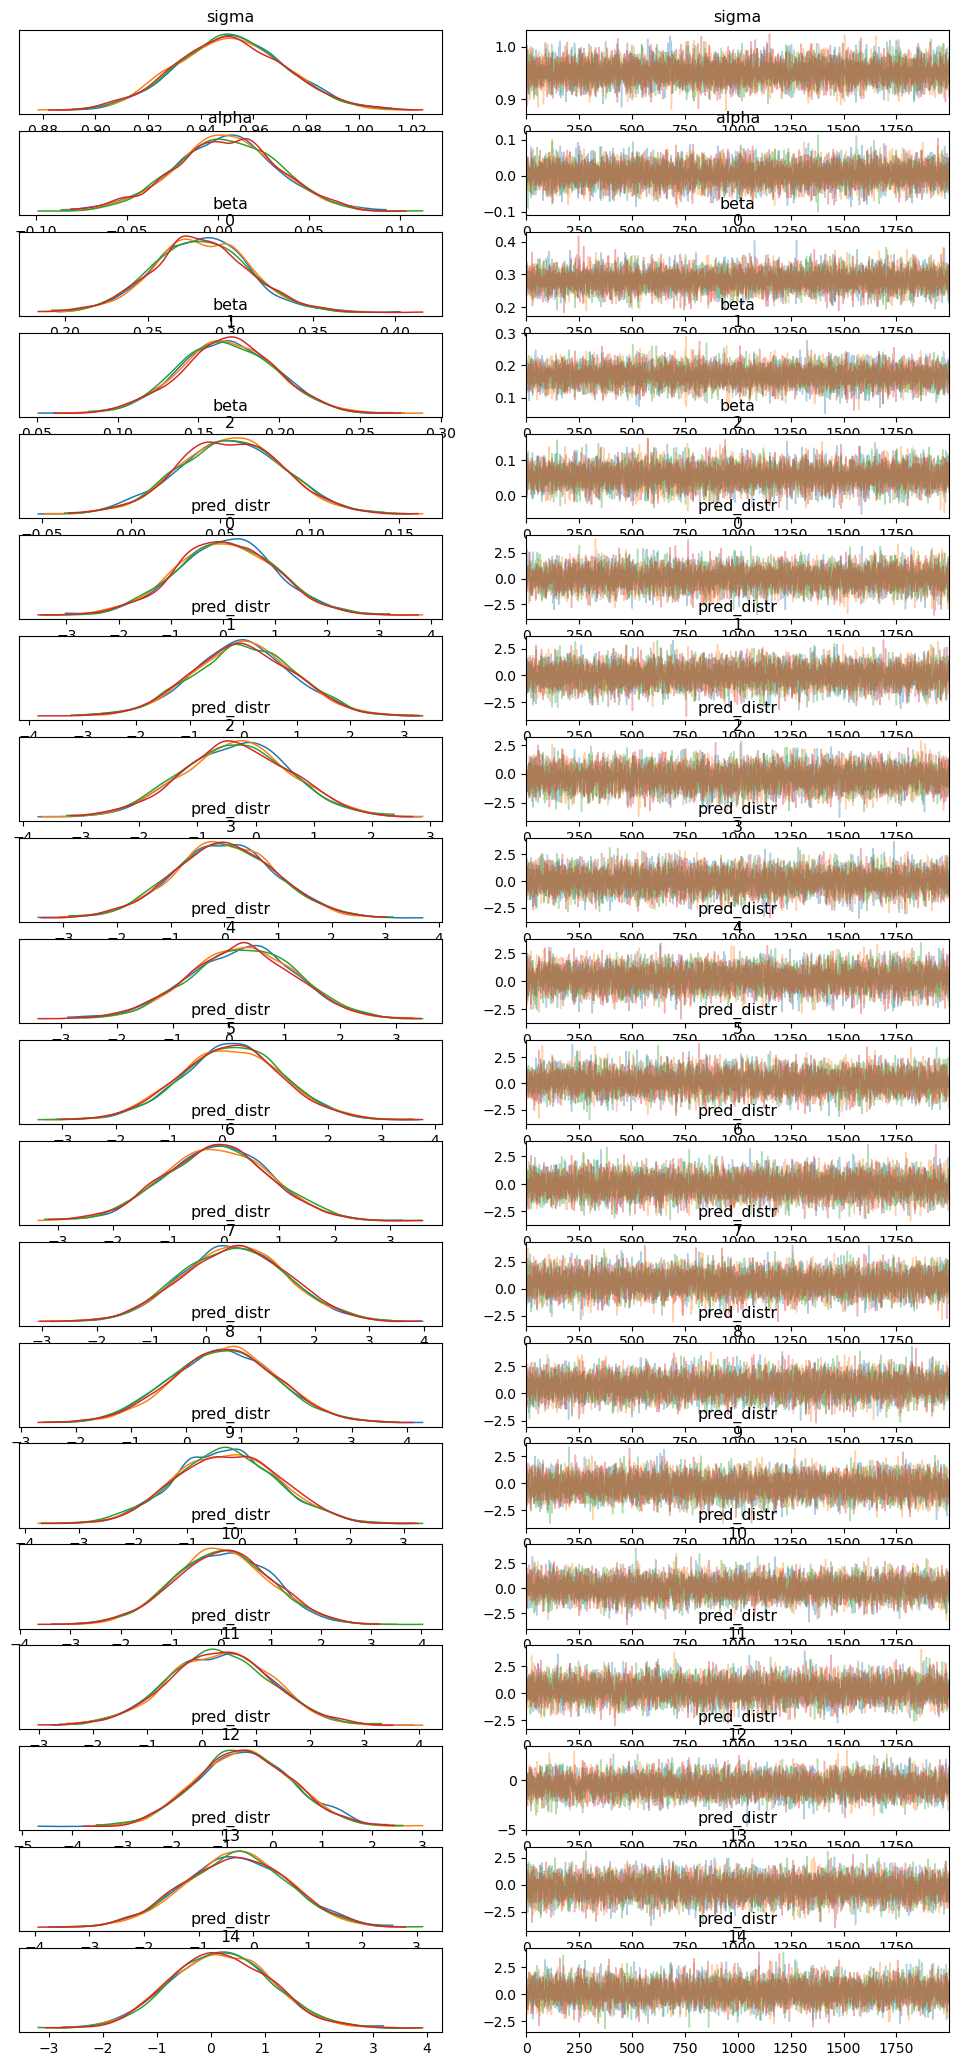

In [175]:
az.plot_trace(fit, compact=False, figsize=(12, 26))

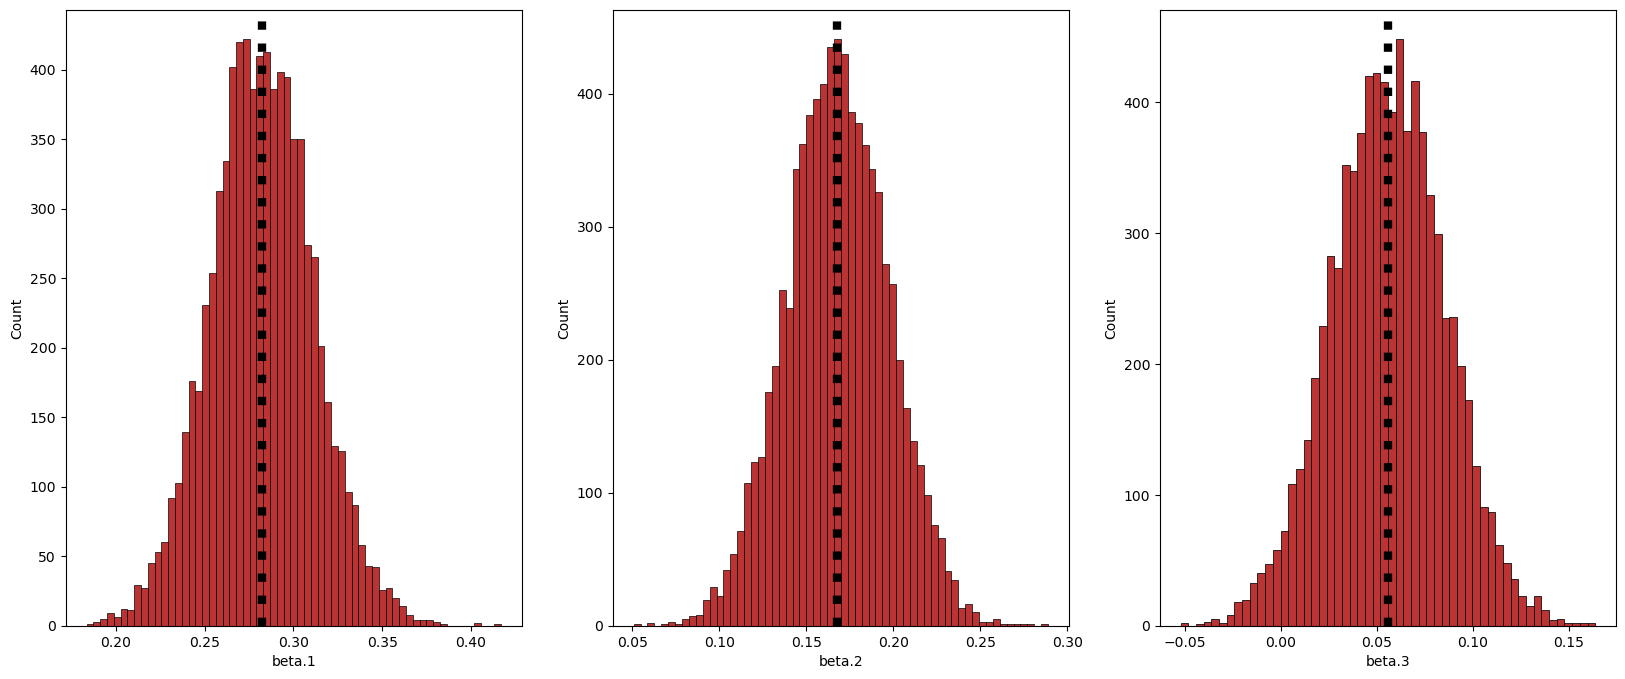

In [176]:
results_frame = fit.to_frame()

f, ax = plt.subplots(1, 3, figsize=(20, 8))

sns.histplot(results_frame, x='beta.1', ax = ax[0], color='#AA0000', alpha=0.8, lw=2)
sns.histplot(results_frame, x='beta.2', ax = ax[1], color='#AA0000', alpha=0.8, lw=2)
sns.histplot(results_frame, x='beta.3', ax = ax[2], color='#AA0000', alpha=0.8, lw=2)

ax[0].axvline(np.mean(results_frame['beta.1']), color='black', linestyle='dotted', lw=6)
ax[1].axvline(np.mean(results_frame['beta.2']), color='black', linestyle='dotted', lw=6)
ax[2].axvline(np.mean(results_frame['beta.3']), color='black', linestyle='dotted', lw=6)

### Problem 4

In [177]:
pred_distr = fit['pred_distr'] #Predictive distribution
num_samples = testing_data_charges.shape[0] #Nunmber of samples
pred_means = np.mean(pred_distr, axis=1) #Predictive distribution means
pred_samples = np.random.choice(pred_means, size=num_samples)

In [178]:
print (pred_samples.shape)
print (testing_data_charges.shape)

#Calculate the RMSE
rmse = np.sqrt((1/num_samples) * np.sum((pred_samples - testing_data_charges)**2))
print(f"RMSE = {rmse}")

(267,)
(267,)
RMSE = 0.9948579668510598
